In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import logging
logging.basicConfig(
            format='%(asctime)s %(levelname)-8s %(message)s',
            level=logging.INFO,
            datefmt='%Y-%m-%d %H:%M:%S')

logger = logging.getLogger()
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

In [5]:
def get_sklearn_gene_imps(dir):
    # TODO: read in from W&B?
    pass

def get_pnet_gene_imps(dir):
    # Read gene_imps from a Pickle file (format: len 20 list --> pandas DFs, samples x genes?)
    with open(os.path.join(dir, 'gene_imps.pkl'), 'rb') as file:
        gene_imps = pickle.load(file)

    # # Read layerwise_imps from a Pickle file (format: len 20 list --> len 5 list --> pandas DF, samples x features)
    # with open(os.path.join(dir, 'layerwise_imps.pkl'), 'rb') as file:
    #     layerwise_imps = pickle.load(file)

    # print(gene_imps[0].shape)
    # for i in range(5):
    #     print(layerwise_imps[0][i].shape)
    return gene_imps

def make_pnet_gene_ranking_df(gene_imps, index):
    """
    For a given sample (aka index / patient), pull the gene rankings from each of the runs (dfs) in gene_imps.

    Inputs:
    - gene_imps: a list of DFs. 
        len(gene_imps) = number of model runs. 
        gene_imps.shape = patients x genes.
    """
    logging.debug("Formatting data")
    # Extract the first row from each DataFrame
    first_rows = [df.iloc[index] for df in gene_imps]

    # Create a DataFrame with the first rows
    first_rows_df = pd.DataFrame(first_rows)

    # Create a DataFrame with rankings for each gene in each row
    rankings_df = first_rows_df.apply(lambda row: row.abs().rank(ascending=False), axis=1)
    return rankings_df


def calc_perpatient_stability_metric(gene_imps):
    logging.info("Calculating patient-level stability metric")
    stabs = []
    for patient_i in range(gene_imps[0].shape[0]):
        rankings_df = make_pnet_gene_ranking_df(gene_imps, patient_i)
        # Compute the average and standard deviation across rows
        average_across_rows = rankings_df.mean(axis=0)
        std_across_rows = rankings_df.std(axis=0)

        # Create a new DataFrame with averages and standard deviations
        summary_df = pd.DataFrame({
            'Average Across Rows': average_across_rows,
            'Std Dev Across Rows': std_across_rows
        })
        summary_df = summary_df.sort_values(by='Average Across Rows', ascending=True)

        filtered_to_imp = summary_df[summary_df['Average Across Rows']<50]
        stability_metric = filtered_to_imp['Std Dev Across Rows'].median()
        stabs.append(stability_metric)
    return stabs


2024-01-12 14:52:56 INFO     Calculating patient-level stability metric
2024-01-12 14:53:03 INFO     Plotting histogram of patient-level stability metric


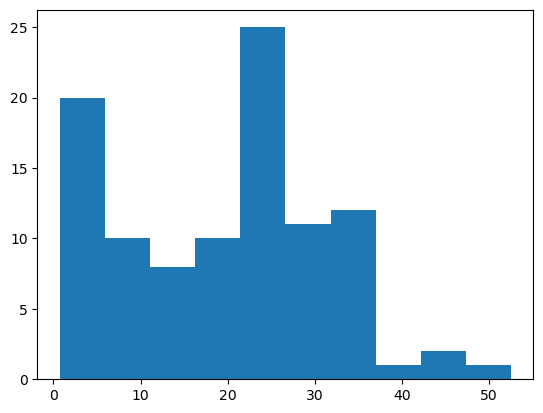

In [7]:
SAVEDIR = '../../pnet/results/gene_rank_stability' # Gwen's (before Mark improved stability)

pnet_gene_imps = get_pnet_gene_imps(SAVEDIR)
pnet_patient_stabs = calc_perpatient_stability_metric(pnet_gene_imps)

logging.info("Plotting histogram of patient-level stability metric")
# median stdev of top 50 genes (top 50 relative to each patient). 
# Pretty darn unstable. 
# For example, a gene at rank 50 with a stdev of 50 means that 68% of the time, its rank was between 0 and 100.
plt.hist(pnet_patient_stabs)
plt.show()

2024-01-12 14:53:04 INFO     Calculating patient-level stability metric


2024-01-12 14:53:14 INFO     Plotting histogram of patient-level stability metric


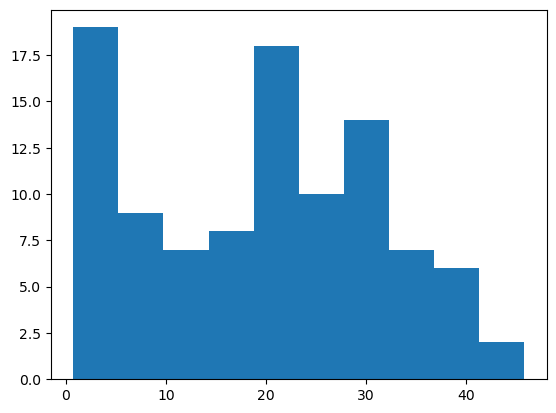

In [8]:
SAVEDIR = '../../pnet/results/gene_rank_stability_v2' # Gwen's (after Mark improved stability)

pnet_gene_imps = get_pnet_gene_imps(SAVEDIR)
pnet_patient_stabs = calc_perpatient_stability_metric(pnet_gene_imps)

logging.info("Plotting histogram of patient-level stability metric")
# median stdev of top 50 genes (top 50 relative to each patient). 
# Pretty darn unstable. 
# For example, a gene at rank 50 with a stdev of 50 means that 68% of the time, its rank was between 0 and 100.
plt.hist(pnet_patient_stabs)
plt.show()

In [ ]:
MODEL_TYPE = "rf"
EVAL_SET = 'test' # val
SAVEDIR = f'../../pnet/results/somatic_{MODEL_TYPE}_eval_set_{EVAL_SET}' # Gwen's

rf_gene_imps = get_sklearn_gene_imps(SAVEDIR)
rf_patient_stabs = calc_perpatient_stability_metric(rf_gene_imps)

logging.info("Plotting histogram of patient-level stability metric")
# median stdev of top 50 genes (top 50 relative to each patient). 
# Pretty darn unstable. 
# For example, a gene at rank 50 with a stdev of 50 means that 68% of the time, its rank was between 0 and 100.
plt.hist(rf_patient_stabs)
plt.show()

In [ ]:
MODEL_TYPE = "bdt"
EVAL_SET = 'test' # val
SAVEDIR = f'../../pnet/results/somatic_{MODEL_TYPE}_eval_set_{EVAL_SET}' # Gwen's

bdt_gene_imps = get_sklearn_gene_imps(SAVEDIR)
bdt_patient_stabs = calc_perpatient_stability_metric(bdt_gene_imps)

logging.info("Plotting histogram of patient-level stability metric")
# median stdev of top 50 genes (top 50 relative to each patient). 
# Pretty darn unstable. 
# For example, a gene at rank 50 with a stdev of 50 means that 68% of the time, its rank was between 0 and 100.
plt.hist(bdt_patient_stabs)
plt.show()